# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.690062036001109
GPU (s):
0.09407736399953137
GPU speedup over CPU: 28x


In [ ]:
import os
import string
import numpy as np
import pandas as pd
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import logging
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import io
import time
import warnings
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
open('/content/drive/My Drive/en_hi_data.zip')

<_io.TextIOWrapper name='/content/drive/My Drive/en_hi_data.zip' mode='r' encoding='UTF-8'>

In [ ]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()
    return w

def hindi_preprocess_sentence(w):
    w = w.rstrip().strip()
    return w

In [ ]:
data='en_hi.pkl'

In [ ]:
def create_dataset(path=data):
 lines=pd.read_pickle(path)
 lines=lines.dropna()
 #lines = lines[lines['source']=='ted']
 en = []
 hd = []
 for i, j in zip(lines['english'], lines['hindi']):
  en_1 = [preprocess_sentence(w) for w in i.split(' ')]
  en_1.append('<end>')
  en_1.insert(0, '<start>')
  hd_1 = [hindi_preprocess_sentence(w) for w in j.split(' ')]
  hd_1.append('<end>')
  hd_1.insert(0, '<start>')
  en.append(en_1)
  hd.append(hd_1)
 return hd, en

In [ ]:
!unzip '/content/drive/My Drive/en_hi_data.zip'

Archive:  /content/drive/My Drive/en_hi_data.zip
replace english_sampled.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace en_hi.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace hindi_sampled.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
PATH='en_hi.pkl'

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
  return tensor, lang_tokenizer

def load_dataset(path=PATH):
    targ_lang, inp_lang = create_dataset('en_hi.pkl')
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(PATH)
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.002)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))


9980 9980 20 20


In [ ]:
print(input_tensor_train[0])

[   1    3  194 6985   24 2374    2]


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))
    
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_val[11])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_val[11])

Input Language; index to word mapping
1 ----> <start>
3 ----> 
40 ----> no ,
1572 ----> horse
477 ----> shit .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
6 ----> -
48 ----> नहीं,
891 ----> घोड़े
23 ----> की
5160 ----> लीद.
2 ----> <end>


In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 128
units = 256
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    hidden_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)
    return x, state, attention_weights

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
#   print(type(mask))
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
    # Teacher forcing
    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))      
  return batch_loss

Epoch 1 Batch 0 Loss 1.2808
Epoch 1 Batch 100 Loss 1.2188
Epoch 1 Loss 1.2391
Time taken for 1 epoch 12.519456148147583 sec

Epoch 2 Batch 0 Loss 1.1551
Epoch 2 Batch 100 Loss 1.1077
Epoch 2 Loss 1.1603
Time taken for 1 epoch 12.417015075683594 sec

Epoch 3 Batch 0 Loss 1.1458
Epoch 3 Batch 100 Loss 1.0952
Epoch 3 Loss 1.0872
Time taken for 1 epoch 12.451569557189941 sec

Epoch 4 Batch 0 Loss 1.0125
Epoch 4 Batch 100 Loss 1.0579
Epoch 4 Loss 1.0309
Time taken for 1 epoch 12.568125009536743 sec

Epoch 5 Batch 0 Loss 0.9256
Epoch 5 Batch 100 Loss 1.0112
Epoch 5 Loss 0.9818
Time taken for 1 epoch 12.04902720451355 sec

Epoch 6 Batch 0 Loss 0.9789
Epoch 6 Batch 100 Loss 0.9032
Epoch 6 Loss 0.9363
Time taken for 1 epoch 12.525524616241455 sec

Epoch 7 Batch 0 Loss 0.9224
Epoch 7 Batch 100 Loss 0.8862
Epoch 7 Loss 0.8944
Time taken for 1 epoch 12.428106307983398 sec

Epoch 8 Batch 0 Loss 0.8572
Epoch 8 Batch 100 Loss 0.8306
Epoch 8 Loss 0.8547
Time taken for 1 epoch 12.409685611724854 sec

E

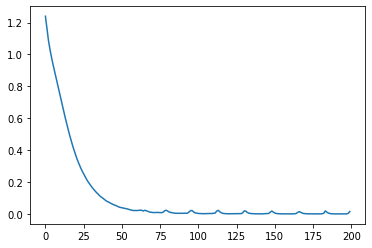

In [ ]:
EPOCHS = 200
train_loss =[]
for epoch in range(EPOCHS):
  start = time.time()
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    
    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  loss = total_loss / steps_per_epoch
  train_loss.append(loss)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      loss))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

xc= range(200)
plt.figure()
plt.plot(xc, train_loss)

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    #sentence = preprocess_sentence(sentence)
    #inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([sentence],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence

In [ ]:
def translate(sentence):
    result, sentence = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    return result

In [ ]:
def convert2(lang, tensor):
  hin_words=[]
  for t in tensor:
    if t!=0:
      
      hin_words.append(lang.index_word[t])
      
  hin_words=hin_words[1:len(hin_words)-2]
  return hin_words

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
i=0
res=[]
act=[]
for sentence in input_tensor_val:
  convert(inp_lang, input_tensor_val[i])
  hindi_w=translate(sentence)
  act=convert2(targ_lang, target_tensor_val[i])
  res=hindi_w.split()
  res=res[0:len(res)-2]
  print("ACTUAL")
  print(act)
  print("TRANSLATED")
  print(res)
  print("BLEU SCORE")
  print('Cumulative 1-gram: %f' % sentence_bleu([act], res, weights=(1, 0, 0, 0)))
  print('Cumulative 2-gram: %f' % sentence_bleu([act], res, weights=(0.5, 0.5, 0, 0)))
  print('Cumulative 3-gram: %f' % sentence_bleu([act], res, weights=(0.33, 0.33, 0.33, 0)))
  print('Cumulative 4-gram: %f' % sentence_bleu([act], res, weights=(0.25, 0.25, 0.25, 0.25)))
  print("===========")
  i=i+1

1 ----> <start>
16 ----> it s
21 ----> not
6 ----> the
1377 ----> th .
2 ----> <end>
Input: [   1   16   21    6 1377    2    0]
Predicted translation: ये इतना ही नहीं है. <end> 
ACTUAL
['आज', '25', 'नहीं']
TRANSLATED
['ये', 'इतना', 'ही', 'नहीं']
BLEU SCORE
Cumulative 1-gram: 0.250000
Cumulative 2-gram: 0.500000
Cumulative 3-gram: 0.632878
Cumulative 4-gram: 0.707107
1 ----> <start>
384 ----> remember
10 ----> what
149 ----> mr .
6741 ----> hallorann
351 ----> said .
2 ----> <end>
Input: [   1  384   10  149 6741  351    2]
Predicted translation: याद है कि क्या कहा कि क्या याद है. <end> 
ACTUAL
['याद', 'करो', 'श्री', 'हैलोरन', 'ने', 'क्या']
TRANSLATED
['याद', 'है', 'कि', 'क्या', 'कहा', 'कि', 'क्या', 'याद']
BLEU SCORE
Cumulative 1-gram: 0.250000
Cumulative 2-gram: 0.500000
Cumulative 3-gram: 0.632878
Cumulative 4-gram: 0.707107
1 ----> <start>
109 ----> thank
78 ----> you ,
149 ----> mr .
655 ----> president .
2 ----> <end>


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Input: [  1 109  78 149 655   2   0]
Predicted translation: तुम्हारा क्रेडिट ठीक है, तो? <end> 
ACTUAL
['मि.']
TRANSLATED
['तुम्हारा', 'क्रेडिट', 'ठीक', 'है,']
BLEU SCORE
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
1 ----> <start>
9 ----> to
89 ----> our
3373 ----> potential
1919 ----> success .
2 ----> <end>
Input: [   1    9   89 3373 1919    2    0]
Predicted translation: उसकी लोग मर जाते हैं. <end> 
ACTUAL
['हमारे', 'संभावित', 'सफलता', 'के']
TRANSLATED
['उसकी', 'लोग', 'मर', 'जाते']
BLEU SCORE
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
1 ----> <start>
10 ----> what
689 ----> brings
4 ----> you
9 ----> to
7839 ----> chunghae ?
2 ----> <end>
Input: [   1   10  689    4    9 7839    2]
Predicted translation: तुम्हें जाने के लिए क्या लाता है? <end> 
ACTUAL
['आप', 'chunghae', 'करने', 'के', 'लिए', 'क्या', 'लाता']
TRANSLATED
['तुम्हें', 'जाने', 'के', 'लिए

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Input: [   1   13   38 1172  794    2    0]
Predicted translation: हम कर सकते हैं मैं कर सकते हैं मैं कर सकते हैं. <end> 
ACTUAL
['हम', 'इस', 'समाप्त', 'कर', 'सकते']
TRANSLATED
['हम', 'कर', 'सकते', 'हैं', 'मैं', 'कर', 'सकते', 'हैं', 'मैं', 'कर', 'सकते']
BLEU SCORE
Cumulative 1-gram: 0.272727
Cumulative 2-gram: 0.165145
Cumulative 3-gram: 0.304642
Cumulative 4-gram: 0.406380
1 ----> <start>
96 ----> tell
91 ----> her
86 ----> from
4669 ----> toljan .
2 ----> <end>
Input: [   1   96   91   86 4669    2    0]
Predicted translation: इसे बेहतर खो दिया? <end> 
ACTUAL
['टॉल्जन', 'की', 'तरफ', 'से', 'उसे']
TRANSLATED
['इसे', 'बेहतर', 'खो']
BLEU SCORE
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
1 ----> <start>
57 ----> he s
7 ----> a
814 ----> grown
179 ----> man .
2 ----> <end>
Input: [  1  57   7 814 179   2   0]
Predicted translation: वह एक बड़ा है. <end> 
ACTUAL
['वह', 'एक', 'बड़ा', 'आदमी']
TRANSLATED
['वह', 'एक', 'बड़ा']
BL

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Input: [   1  226    9  126 1002    2    0]
Predicted translation: मुझे नहीं है. <end> 
ACTUAL
['मेरी', 'बात', 'सुनो,']
TRANSLATED
['मुझे', 'नहीं']
BLEU SCORE
Cumulative 1-gram: 0.000000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
1 ----> <start>
80 ----> his
1214 ----> passport
17 ----> and
7876 ----> application
2411 ----> form
2 ----> <end>
Input: [   1   80 1214   17 7876 2411    2]
Predicted translation: मेरी लड़की ही लो और तो? <end> 
ACTUAL
['उसका', 'पासपोर्ट', 'और', 'आवेदन']
TRANSLATED
['मेरी', 'लड़की', 'ही', 'लो', 'और']
BLEU SCORE
Cumulative 1-gram: 0.200000
Cumulative 2-gram: 0.447214
Cumulative 3-gram: 0.587949
Cumulative 4-gram: 0.668740
1 ----> <start>
39 ----> that s
3545 ----> anything ,
3546 ----> basically ,
1991 ----> standard .
2 ----> <end>
Input: [   1   39 3545 3546 1991    2    0]
Predicted translation: यह हमारी मानक जाता है। <end> 
ACTUAL
['यह', 'सामान्य', 'बात']
TRANSLATED
['यह', 'हमारी', 'मानक', 'जाता']
BLEU SCORE
Cumulativ